# RAGdoll Key Modules Demo

Hands-on walkthrough for ingestion, chunking, embeddings, storage layers, and orchestration. Every example relies on the sample assets under `tests/test_data`, so the notebook can run offline.

> **Note:** 
- Set `USE_OPENAI = True` at the top to use real OpenAI embeddings, `False` for fake embeddings.
- Cells 7 and 9 call OpenAI's GPT endpoints via `get_llm_caller`. Export `OPENAI_API_KEY` (or add it to `.env`) before running them.
- **SSL Certificate Issues**: If you encounter `SSL: CERTIFICATE_VERIFY_FAILED` errors (common in corporate networks), see the SSL workaround cell below to disable verification for development purposes.

## What you'll see

1. **Ingestion** – `DocumentLoaderService` from [`docs/ingestion.md`](../docs/ingestion.md).
2. **Chunking** – `ragdoll.chunkers` helpers from [`docs/chunking.md`](../docs/chunking.md).
3. **Embeddings** – provider factory from [`docs/embeddings.md`](../docs/embeddings.md) controlled by USE_OPENAI flag.
4. **Vector stores** – `vector_store_from_config` customization from [`docs/vector_stores.md`](../docs/vector_stores.md).
5. **Graph stores** – `get_graph_store` JSON persistence from [`docs/graph_stores.md`](../docs/graph_stores.md).
6. **Entity extraction** – `EntityExtractionService` for building knowledge graphs.
7. **LLMs** – `get_llm_caller`/`call_llm_sync` bridge described in [`docs/llm_integration.md`](../docs/llm_integration.md) hitting your real OpenAI model.
8. **Pipeline** – `IngestionPipeline` snapshot from [`docs/architecture.md`](../docs/architecture.md).
9. **Retrieval** – New modular retrieval system with `VectorRetriever`, `GraphRetriever`, and `HybridRetriever` from [`docs/retrieval.md`](../docs/retrieval.md).
10. **Advanced Patterns** – Hybrid retrieval modes, graph traversal strategies, and async retrieval.

Each cell builds on the previous ones so you can treat this as a scratchpad for experimenting with new loaders or configuration overrides.

In [1]:
from pathlib import Path
from pprint import pprint
import shutil
import time

from langchain_core.documents import Document

from ragdoll import Ragdoll
from ragdoll.app_config import bootstrap_app
from ragdoll.ingestion import DocumentLoaderService
from ragdoll.chunkers import get_text_splitter, split_documents
from ragdoll.embeddings import get_embedding_model
from ragdoll.vector_stores import vector_store_from_config
from ragdoll.config.base_config import VectorStoreConfig
from ragdoll.graph_stores import get_graph_store
from ragdoll.entity_extraction import EntityExtractionService
from ragdoll.entity_extraction.models import Graph, GraphNode, GraphEdge
from ragdoll.entity_extraction.graph_persistence import GraphPersistenceService
from ragdoll.retrieval import VectorRetriever, GraphRetriever, HybridRetriever
from ragdoll.llms import get_llm_caller
from ragdoll.llms.callers import call_llm_sync
from ragdoll.pipeline import ingest_documents, IngestionPipeline, IngestionOptions
from dotenv import load_dotenv

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
load_dotenv(override=True)

DATA_DIR = Path('../tests/test_data').resolve()
STATE_DIR = Path('demo_state').resolve()
STATE_DIR.mkdir(exist_ok=True)

SAMPLE_TXT = DATA_DIR / 'test_txt.txt'
#SAMPLE_TXT = DATA_DIR / '*'

# Set to True to use real OpenAI embeddings, False for fake embeddings
USE_OPENAI = True

app_config = bootstrap_app(
    overrides={
        'monitor': {'enabled': False, 'collect_metrics': False},
    }
)


def normalize_documents(raw_docs):
    docs = []
    for entry in raw_docs:
        if isinstance(entry, Document):
            docs.append(entry)
        elif isinstance(entry, dict):
            docs.append(
                Document(
                    page_content=str(entry.get('page_content', '')),
                    metadata=entry.get('metadata', {}) or {},
                )
            )
        else:
            docs.append(Document(page_content=str(entry), metadata={}))
    return docs


def reset_subdir(name: str) -> Path:
    path = STATE_DIR / name
    if path.exists():
        for attempt in range(5):
            try:
                shutil.rmtree(path)
                break
            except PermissionError:
                time.sleep(0.5)
        else:
            timestamped = STATE_DIR / f"{name}_{int(time.time())}"
            timestamped.mkdir(parents=True, exist_ok=True)
            print(f"Warning: {path} was locked, using {timestamped} instead.")
            return timestamped
    path.mkdir(parents=True, exist_ok=True)
    return path

In [3]:
import os
k = os.getenv("OPENAI_API_KEY")
print("Key len:", len(k), "prefix:", k[:12], "suffix:", k[-6:])

Key len: 164 prefix: sk-proj-Ml-_ suffix: NUDc8A


## 1. Load sample data
`DocumentLoaderService` fans out across the loader registry defined in `ragdoll/config/default_config.yaml`. We point it at the lightweight TXT fixture so the demo does not need optional dependencies.


In [4]:
loader = DocumentLoaderService(
    app_config=app_config,
    use_cache=False,
    collect_metrics=False,
)

raw_documents = loader.ingest_documents([str(SAMPLE_TXT)])
documents = normalize_documents(raw_documents)

print(f"Loaded {len(documents)} document(s) from {SAMPLE_TXT.name}")
print('Metadata sample:')
pprint(documents[0].metadata)
print('Preview:')
print(documents[0].page_content[:400])


Loaded 1 document(s) from test_txt.txt
Metadata sample:
{'source': 'C:\\dev\\RAGdoll\\tests\\test_data\\test_txt.txt'}
Preview:
Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems by structuring retrieved information into a dynamic knowledge graph rather than treating it as flat text chunks. At its core, it begins with a user query that triggers a retrieval step from a vector database or search index. Instead of directly feeding retrieved documents into a


## 2. Chunk documents
`ragdoll.chunkers.get_text_splitter` mirrors the strategies in [`docs/chunking.md`](../docs/chunking.md). Reusing the splitter instance keeps experiments consistent when you tweak chunk sizes/overlap.


In [5]:
splitter = get_text_splitter(
    splitter_type='recursive',
    chunk_size=250,
    chunk_overlap=40,
    app_config=app_config,
)
chunks = split_documents(documents, text_splitter=splitter)

print(f"Created {len(chunks)} chunk(s)")
for idx, chunk in enumerate(chunks[:3], start=1):
    preview = chunk.page_content[:180].replace('\n', ' ')
    print(f"Chunk {idx} metadata: {chunk.metadata}")
    print(preview)
    print('---')


Created 20 chunk(s)
Chunk 1 metadata: {'source': 'C:\\dev\\RAGdoll\\tests\\test_data\\test_txt.txt', 'chunk_id': '7623481e_0_v1'}
Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems by structuring retrieved information into a dynamic knowled
---
Chunk 2 metadata: {'source': 'C:\\dev\\RAGdoll\\tests\\test_data\\test_txt.txt', 'chunk_id': '7623481e_1_v1'}
it as flat text chunks. At its core, it begins with a user query that triggers a retrieval step from a vector database or search index. Instead of directly feeding retrieved docume
---
Chunk 3 metadata: {'source': 'C:\\dev\\RAGdoll\\tests\\test_data\\test_txt.txt', 'chunk_id': '7623481e_2_v1'}
the system parses these documents to extract entities (such as people, organizations, or concepts) and relationships (like "works at" or "caused by") using named entity recognition
---


## 3. Create embeddings
`ragdoll.embeddings.get_embedding_model` instantiates providers dynamically. Passing `provider="fake"` gives deterministic vectors without hitting OpenAI/HuggingFace, but the rest of the flow matches production usage.


In [6]:
#print(os.getenv("OPENAI_API_KEY"))

In [7]:
embedding_inputs = [chunk.page_content for chunk in chunks[:3]]
if not embedding_inputs:
    embedding_inputs = [documents[0].page_content]

embeddings = (
    get_embedding_model() if USE_OPENAI 
    else get_embedding_model(provider='fake', size=256)
)
vectors = embeddings.embed_documents(embedding_inputs)

print(f"Generated {len(vectors)} embedding vector(s) with dimension {len(vectors[0])}")
print('First vector slice:', vectors[0][:8])

Generated 3 embedding vector(s) with dimension 1536
First vector slice: [-0.0021977098658680916, 0.01036502793431282, -0.011459833942353725, 0.009982817806303501, -0.004256139509379864, -0.01772419735789299, -0.015832580626010895, -0.014394433237612247]


## 4. Build a vector store
`vector_store_from_config` consumes a `VectorStoreConfig`, so you can swap FAISS/Chroma/etc. on demand. This cell provisions a Chroma collection under `demo_state` and runs a quick similarity query.


In [8]:
core_store_dir = reset_subdir('chroma_core_demo')
vector_config = VectorStoreConfig(
    enabled=True,
    store_type='chroma',
    params={
        'collection_name': 'ragdoll_core_demo',
        'persist_directory': str(core_store_dir),
    },
)

demo_vector_store = vector_store_from_config(
    vector_config,
    embedding=embeddings,
)

demo_vector_store.add_documents(chunks)
question = 'What content lives in the txt sample?'
results = demo_vector_store.similarity_search(question, k=2)
for idx, doc in enumerate(results, start=1):
    snippet = doc.page_content[:160].replace('\n', ' ')
    print(f"Result {idx} (source={doc.metadata.get('source')}) -> {snippet}")


Result 1 (source=C:\dev\RAGdoll\tests\test_data\test_txt.txt) -> it as flat text chunks. At its core, it begins with a user query that triggers a retrieval step from a vector database or search index. Instead of directly feed
Result 2 (source=C:\dev\RAGdoll\tests\test_data\test_txt.txt) -> Finally, the output includes not just the generated text but optional graph visualizations or citations mapping back to original documents. This traceability im


## 5. Run entity extraction + persist a graph
`EntityExtractionService` runs spaCy over the chunks and hands everything to `GraphPersistenceService`. We disable re-chunking, dump the output to JSON under `demo_state/`, and render a quick visualization so you can inspect the extracted entities before wiring them into a retriever.

In [9]:
import os

# Create directories
graph_store_dir = reset_subdir('graph_demo')
graph_image_path = graph_store_dir / 'graph_demo.png'
graph_store_file = graph_store_dir / 'graph.pkl'

class ExampleFallbackLLM:
    async def call(self, prompt: str) -> str:
        return "Fallback response (no API key for entity extraction)"
    # Initialize LLM
if not os.getenv('OPENAI_API_KEY'):
    print("OPENAI_API_KEY not set, using fallback LLM for demo.")
    llm_caller = ExampleFallbackLLM()
else:
    llm_caller = get_llm_caller(app_config=app_config)
    if llm_caller is None:
        print("Unable to initialize LLM, using fallback.")
        llm_caller = ExampleFallbackLLM()
    else:
        print("LLM initialized for entity extraction.")

# Configure ingestion options - use the shared embeddings from earlier
options = IngestionOptions(
    batch_size=5,
    extract_entities=True,
    chunking_options={'chunk_size': 1000, 'chunk_overlap': 200},
    vector_store_options={
        "store_type": "chroma",
        "params": {
            "collection_name": "graph_demo",
            "persist_directory": str(graph_store_dir / "vector"),
        },
    },
    graph_store_options={
        "store_type": "networkx",
        "output_file": str(graph_store_file),
    },
    llm_caller=llm_caller,
    entity_extraction_options={
        "entity_types": ["Person", "Organization", "Location"],
    },
)


LLM initialized for entity extraction.


✅ Ingestion complete!
Documents processed: 1
Chunks created: 5
Entities extracted: 78
Relationships extracted: 40
Vector entries added: 5
Graph entries added: 40

Visualizing graph with 78 nodes and 40 edges...

Graph visualization saved as 'C:\dev\RAGdoll\examples\demo_state\graph_demo\graph_demo.png'
Graph data saved as 'C:\dev\RAGdoll\examples\demo_state\graph_demo\graph_output.json'

Graph visualization saved as 'C:\dev\RAGdoll\examples\demo_state\graph_demo\graph_demo.png'
Graph data saved as 'C:\dev\RAGdoll\examples\demo_state\graph_demo\graph_output.json'


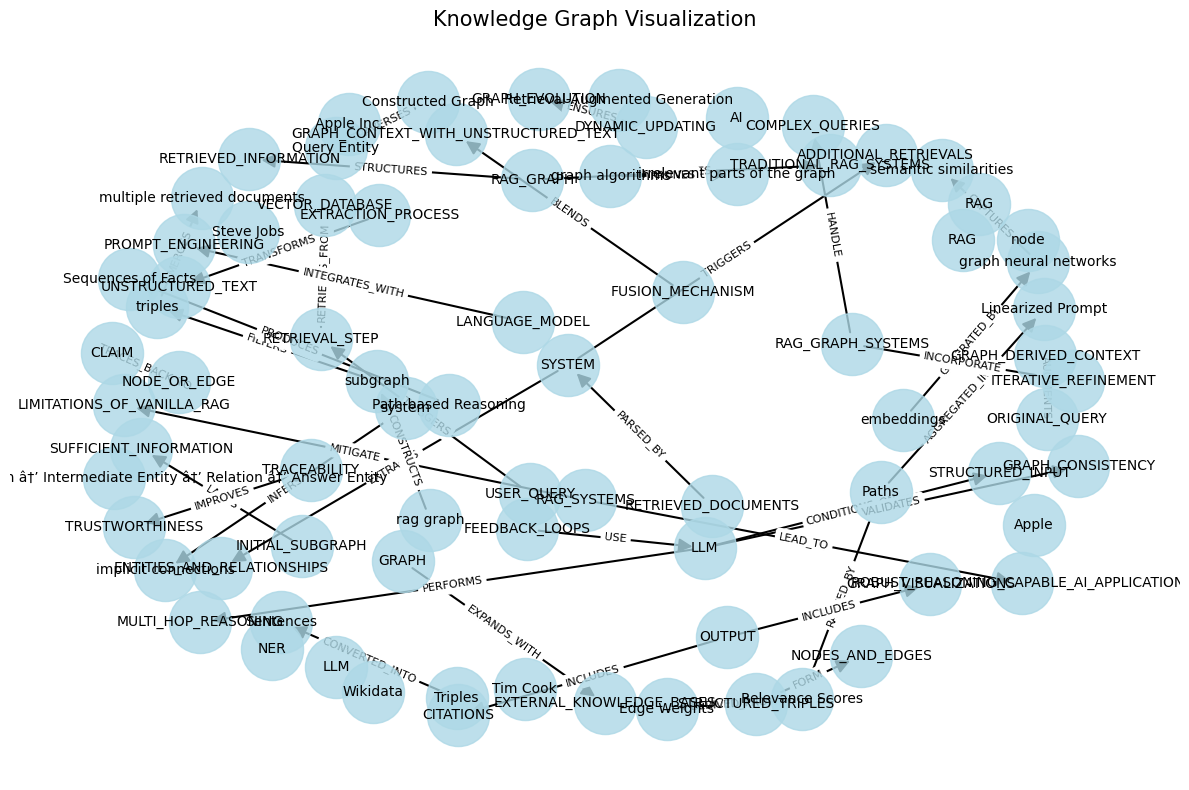

In [10]:
# Run ingestion using ingest_documents helper (cleaner approach)
from ragdoll.pipeline import ingest_documents
from ragdoll.utils import visualize_graph

sources = [str(SAMPLE_TXT)]

# Use ingest_documents which properly handles everything
result = await ingest_documents(sources, options=options)
stats = result.get("stats", {})
graph = result.get("graph")
graph_store = result.get("graph_store")
graph_retriever = result.get("graph_retriever")
pipeline_vector_store = result.get("vector_store")  # Vector store with graph node embeddings

# Print results
print(f"✅ Ingestion complete!")
print(f"Documents processed: {stats.get('documents_processed')}")
print(f"Chunks created: {stats.get('chunks_created')}")
print(f"Entities extracted: {stats.get('entities_extracted')}")
print(f"Relationships extracted: {stats.get('relationships_extracted')}")
print(f"Vector entries added: {stats.get('vector_entries_added')}")
print(f"Graph entries added: {stats.get('graph_entries_added')}")

if stats.get("errors"):
    print(f"⚠️ Warnings/Errors:")
    for error in stats["errors"]:
        print(f"  - {error}")

# Visualize using the utility function (same as graph_rag_ingestion.py)
if graph and hasattr(graph, 'nodes') and graph.nodes:
    print(f"\nVisualizing graph with {len(graph.nodes)} nodes and {len(graph.edges)} edges...")
    visualize_graph(graph, output_image_path=str(graph_image_path), output_json_path=str(graph_store_dir / "graph_output.json"))
else:
    print('No graph available to visualize.')


In [ ]:
# Reload modules to get latest changes
import importlib
import ragdoll.entity_extraction.entity_extraction_service
import ragdoll.pipeline
importlib.reload(ragdoll.entity_extraction.entity_extraction_service)
importlib.reload(ragdoll.pipeline)
from ragdoll.pipeline import ingest_from_vector_store
print("✅ Reloaded modules with latest extract_from_vector_store functionality")

✅ Reloaded pipeline module with ingest_from_vector_store


## 5c. Extract Entities from Existing Vector Store (Alternative Approach)

This demonstrates extracting entities from an already-populated vector store. This approach **guarantees** that graph nodes have vector_id references matching the vector store, eliminating ID mismatch issues.

**Use cases:**
- Add graph capabilities to existing vector stores
- Ensure graph nodes reference valid vector IDs
- Process documents that are already chunked and embedded

In [20]:
# Extract entities from the demo_vector_store created in Section 4
# This ensures graph nodes have vector_ids that match the vector store

if 'demo_vector_store' in globals():
    print("=== Extracting Entities from Existing Vector Store ===\n")
    
    from ragdoll.pipeline import ingest_from_vector_store
    
    # Create output directory for this alternative approach
    vs_graph_dir = reset_subdir('vs_extracted_graph')
    
    # Extract entities directly from demo_vector_store
    vs_graph_result = await ingest_from_vector_store(
        vector_store=demo_vector_store,
        embedding_model=embeddings,
        options=IngestionOptions(
            batch_size=5,
            entity_extraction_options={
                "entity_types": ["Person", "Organization", "Location", "Technology"],
                "use_llm": True,
            },
            llm_caller=llm_caller,
            graph_store_options={
                "store_type": "networkx",
                "output_file": str(vs_graph_dir / "graph.pkl"),
            }
        ),
        app_config=app_config
    )
    
    vs_graph = vs_graph_result.get("graph")
    vs_graph_store = vs_graph_result.get("graph_store")
    vs_graph_retriever = vs_graph_result.get("graph_retriever")
    vs_stats = vs_graph_result.get("stats", {})
    
    print(f"✅ Extraction from vector store complete!")
    print(f"   Entities found: {vs_stats.get('entities_extracted', 0)}")
    print(f"   Relationships found: {vs_stats.get('relationships_extracted', 0)}")
    
    # Verify nodes have vector_id references
    if vs_graph and vs_graph.nodes:
        nodes_with_vector_id = sum(1 for node in vs_graph.nodes 
                                   if 'vector_id' in getattr(node, 'properties', {}))
        print(f"   Nodes with vector_id: {nodes_with_vector_id}/{len(vs_graph.nodes)} ✅")
        
        # Show sample nodes with their vector_ids
        print("\n📌 Sample nodes with vector_id references:")
        for node in list(vs_graph.nodes)[:5]:
            props = getattr(node, 'properties', {})
            vector_id = props.get('vector_id', 'N/A')
            entity_name = props.get('name') or props.get('text', node.id)
            print(f"   - [{node.type}] {entity_name}")
            print(f"     vector_id: {vector_id[:36]}...")
    
    # Test retrieval with this graph
    if vs_graph_retriever:
        print("\n=== Testing Retrieval with Vector Store Extracted Graph ===")
        
        test_query = "What entities are mentioned in the documents?"
        test_results = vs_graph_retriever.get_relevant_documents(test_query)
        
        # Get retriever stats
        retriever_stats = vs_graph_retriever.get_stats()
        print(f"Graph stats: {retriever_stats.get('node_count', 0)} nodes, "
              f"{retriever_stats.get('indexed_nodes', 0)} indexed")
        
        print(f"\nRetrieved {len(test_results)} nodes for query: '{test_query}'")
        for idx, doc in enumerate(test_results[:5], start=1):
            node_type = doc.metadata.get('node_type', 'unknown')
            node_id = doc.metadata.get('node_id', 'unknown')
            relevance = doc.metadata.get('relevance_score', 0)
            content_preview = doc.page_content[:100].replace('\n', ' ')
            print(f"{idx}. [{node_type}] (score: {relevance:.3f})")
            print(f"   {content_preview}...")
    
    print("\n✅ Vector store extraction complete!")
    print("📝 Note: This approach guarantees graph node vector_ids match the vector store IDs")
    
else:
    print("⚠️  Run Section 4 first to create demo_vector_store")

=== Extracting Entities from Existing Vector Store ===



AttributeError: 'EntityExtractionService' object has no attribute 'extract_from_vector_store'

## 5b. Alternative: Using IngestionPipeline Directly (OPTIONAL - Keep Commented)

**⚠️ Note:** This cell is commented out to avoid interfering with Section 9's graph retrieval demos. 

The manual pipeline approach creates additional graph stores that can conflict with the `graph_store` variable used in later cells. If you want to test this approach, run it separately or ensure later cells use `manual_graph_store` instead of `graph_store`.

In [11]:
# ## Alternative approach: Create pipeline manually for fine-grained control
# from ragdoll.pipeline import IngestionPipeline, IngestionOptions
# from ragdoll.vector_stores import vector_store_from_config

# ## Setup directories for the manual pipeline demo
# manual_graph_dir = reset_subdir('graph_manual_demo')
# manual_graph_file = manual_graph_dir / 'graph.pkl'
# manual_graph_image = manual_graph_dir / 'manual_graph.png'

# ## Create a fresh vector store for this demo
# manual_vector_store = vector_store_from_config(
#     VectorStoreConfig(
#         enabled=True,
#         store_type="chroma",
#         params={
#             "collection_name": "manual_graph_demo",
#             "persist_directory": str(manual_graph_dir / "vector"),
#         },
#     ),
#     embedding=embeddings,
# )

# ## Configure options with explicit graph store settings
# manual_options = IngestionOptions(
#     batch_size=5,
#     extract_entities=True,
#     chunking_options={'chunk_size': 1000, 'chunk_overlap': 200},
#     graph_store_options={
#         "store_type": "networkx",  # This will be passed through now
#         "output_file": str(manual_graph_file),  # This will be passed through now
#     },
#     llm_caller=llm_caller,
#     entity_extraction_options={
#         "entity_types": ["Person", "Organization", "Location", "Event"],
#     },
# )

# ## Create the pipeline with all our custom components
# manual_pipeline = IngestionPipeline(
#     app_config=app_config,
#     content_extraction_service=DocumentLoaderService(
#         app_config=app_config,
#         use_cache=False,
#         collect_metrics=False,
#     ),
#     embedding_model=embeddings,
#     vector_store=manual_vector_store,
#     options=manual_options,
# )

# ## Run ingestion
# manual_sources = [str(SAMPLE_TXT)]
# manual_stats = await manual_pipeline.ingest(manual_sources)
# manual_graph = manual_pipeline.last_graph
# manual_graph_store = manual_pipeline.get_graph_store()

# # Print results
# print(f"✅ Manual Pipeline Ingestion complete!")
# print(f"Documents processed: {manual_stats.get('documents_processed')}")
# print(f"Chunks created: {manual_stats.get('chunks_created')}")
# print(f"Entities extracted: {manual_stats.get('entities_extracted')}")
# print(f"Relationships extracted: {manual_stats.get('relationships_extracted')}")
# print(f"Vector entries added: {manual_stats.get('vector_entries_added')}")
# print(f"Graph entries added: {manual_stats.get('graph_entries_added')}")
# print(f"Graph store type: {type(manual_graph_store).__name__ if manual_graph_store else 'None'}")

# ## Visualize the manually created graph
# if manual_graph and hasattr(manual_graph, 'nodes') and manual_graph.nodes:
#     print(f"\nVisualizing manual pipeline graph with {len(manual_graph.nodes)} nodes and {len(manual_graph.edges)} edges...")
#     visualize_graph(
#         manual_graph, 
#         output_image_path=str(manual_graph_image), 
#         output_json_path=str(manual_graph_dir / "manual_graph_output.json")
#     )
# else:
#     print('No graph available from manual pipeline.')


## 6. Query vector + graph context
`GraphPersistenceService` reloads the extracted graph into a LangChain retriever so we can compare vector hits against graph nodes for the same question. This mirrors the hybrid pattern we feed into the orchestration demo later on.

In [12]:
# Demonstrate comparing vector and graph retrieval side-by-side
# This shows the complementary nature of the two approaches

hybrid_question = 'Which people or organizations are mentioned in the txt sample?'

# Vector retrieval: semantic similarity to the question
print("=== Vector Retrieval ===")
vector_hits = demo_vector_store.similarity_search(hybrid_question, k=2)
print(f"Vector store returned {len(vector_hits)} document(s)")
for idx, doc in enumerate(vector_hits, start=1):
    snippet = doc.page_content[:200].replace('\n', ' ')
    print(f"- Vector hit {idx} (source={doc.metadata.get('source')}): {snippet}\n")

# Graph retrieval: entity-based traversal (using modern API)
if 'graph_store' in globals() and graph_store is not None:
    print("=== Graph Retrieval ===")
    
    # Use the vector store from the pipeline (contains embeddings for graph nodes)
    graph_vector_store = pipeline_vector_store if 'pipeline_vector_store' in globals() else demo_vector_store
    
    # Create graph retriever with embedding-based seed search
    graph_retriever_demo = GraphRetriever(
        graph_store=graph_store,
        vector_store=graph_vector_store,
        embedding_model=embeddings,
        top_k=3,
        max_hops=1,
        include_edges=True
    )
    
    graph_hits = graph_retriever_demo.get_relevant_documents(hybrid_question)
    print(f"Graph retriever returned {len(graph_hits)} node(s)")
    for doc in graph_hits:
        node_id = doc.metadata.get('node_id', 'unknown')
        node_type = doc.metadata.get('node_type', 'unknown')
        print(f"- Node: {node_type} '{node_id}'")
        print(f"  Content: {doc.page_content[:200]}\n")
else:
    print("\n(Graph store not available - run Section 5 to create it)")

=== Vector Retrieval ===
Vector store returned 2 document(s)
- Vector hit 1 (source=C:\dev\RAGdoll\tests\test_data\test_txt.txt): the system parses these documents to extract entities (such as people, organizations, or concepts) and relationships (like "works at" or "caused by") using named entity recognition (NER) and relation 

- Vector hit 2 (source=C:\dev\RAGdoll\tests\test_data\test_txt.txt): Finally, the output includes not just the generated text but optional graph visualizations or citations mapping back to original documents. This traceability improves trustworthiness, especially in do

=== Graph Retrieval ===
Vector store returned 2 document(s)
- Vector hit 1 (source=C:\dev\RAGdoll\tests\test_data\test_txt.txt): the system parses these documents to extract entities (such as people, organizations, or concepts) and relationships (like "works at" or "caused by") using named entity recognition (NER) and relation 

- Vector hit 2 (source=C:\dev\RAGdoll\tests\test_data\test_txt.txt

Failed to retrieve any embeddings from vector store
No embeddings available for nodes, falling back to fuzzy matching
No embeddings available for nodes, falling back to fuzzy matching


Graph retrieval error: 'method' object is not subscriptable
Graph retriever returned 0 node(s)


## 6b. Save and Load Graph

Demonstrate how to persist and reload the graph using `GraphStoreWrapper`.

In [13]:
# Save and load graph demonstration
if 'graph_store' in globals() and graph_store is not None and 'graph' in globals():
    print("=== Saving Graph ===")
    
    # The graph is already persisted to disk via the pickle file from Section 5
    # But we can also save it programmatically using the Graph object
    save_path = graph_store_dir / "saved_graph.pkl"
    
    # Save using NetworkX pickle
    import pickle
    with open(save_path, 'wb') as f:
        pickle.dump(graph_store.store, f)
    
    print(f"✅ Graph saved to: {save_path}")
    print(f"   Nodes: {graph_store.store.number_of_nodes()}")
    print(f"   Edges: {graph_store.store.number_of_edges()}\n")
    
    # Load the graph back from file
    print("=== Loading Graph ===")
    from ragdoll.graph_stores import GraphStoreWrapper
    import networkx as nx
    
    # Load NetworkX graph from pickle
    with open(save_path, 'rb') as f:
        loaded_nx_graph = pickle.load(f)
    
    # Wrap in GraphStoreWrapper
    loaded_graph_store = GraphStoreWrapper(
        store_type="networkx",
        store_impl=loaded_nx_graph,
        config={}
    )
    
    print(f"✅ Graph loaded from: {save_path}")
    print(f"   Nodes: {loaded_graph_store.store.number_of_nodes()}")
    print(f"   Edges: {loaded_graph_store.store.number_of_edges()}\n")
    
    # Verify the loaded graph works with retrieval
    print("=== Testing Loaded Graph with Retrieval ===")
    
    test_retriever = GraphRetriever(
        graph_store=loaded_graph_store,
        vector_store=demo_vector_store,
        embedding_model=embeddings,
        top_k=3,
        max_hops=1
    )
    
    test_query = "What entities are in the document?"
    test_results = test_retriever.get_relevant_documents(test_query)
    
    print(f"Retrieved {len(test_results)} nodes from loaded graph")
    for idx, doc in enumerate(test_results[:3], start=1):
        node_type = doc.metadata.get('node_type', 'unknown')
        node_id = doc.metadata.get('node_id', 'unknown')
        print(f"{idx}. [{node_type}] {node_id}")
    
    print("\n✅ Save/load cycle successful!")
else:
    print("Graph or graph_store not available. Run Section 5 first.")

Failed to retrieve any embeddings from vector store
No embeddings available for nodes, falling back to fuzzy matching
No embeddings available for nodes, falling back to fuzzy matching


=== Saving Graph ===
✅ Graph saved to: C:\dev\RAGdoll\examples\demo_state\graph_demo\saved_graph.pkl
   Nodes: 78
   Edges: 40

=== Loading Graph ===
✅ Graph loaded from: C:\dev\RAGdoll\examples\demo_state\graph_demo\saved_graph.pkl
   Nodes: 78
   Edges: 40

=== Testing Loaded Graph with Retrieval ===
Graph retrieval error: 'method' object is not subscriptable
Retrieved 0 nodes from loaded graph

✅ Save/load cycle successful!


## 7. Wire up an LLM caller
`get_llm_caller` now instantiates the OpenAI chat model defined in `ragdoll/config/default_config.yaml` (defaults to `gpt-4o-mini`). Make sure `OPENAI_API_KEY` is available before running the next cell.


In [14]:
import os

if not os.getenv('OPENAI_API_KEY'):
    raise EnvironmentError('Set OPENAI_API_KEY before calling the real OpenAI demo cell.')

openai_llm_caller = get_llm_caller(app_config=app_config)

sample_text = chunks[0].page_content if chunks else documents[0].page_content
prompt = (
    'Summarize the following text sample in one sentence. Mention what the document is about and highlight any key people, organizations, or actions.'
    f"{sample_text[:2048]}"
)
print('Sample excerpt:', sample_text[:360].replace('\n', ' '))
llm_reply = call_llm_sync(openai_llm_caller, prompt)
print('OpenAI response:', llm_reply)


Sample excerpt: Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems by structuring retrieved information into a dynamic knowledge graph rather than treating it as flat text chunks. At its core, it
OpenAI response: The document discusses Rag graph, an advanced Retrieval-Augmented Generation system that organizes retrieved information into a dynamic knowledge graph, improving upon traditional methods that use flat text chunks.
OpenAI response: The document discusses Rag graph, an advanced Retrieval-Augmented Generation system that organizes retrieved information into a dynamic knowledge graph, improving upon traditional methods that use flat text chunks.


## 8. Run the ingestion pipeline (async)
`IngestionPipeline` stitches together the loader, chunker, embeddings, vector store, and optional graph/entity stages. We disable entity extraction to keep the run lightweight and await the coroutine directly inside the notebook.


In [15]:
pipeline_store_dir = reset_subdir('chroma_pipeline_demo')
pipeline_vector_config = VectorStoreConfig(
    enabled=True,
    store_type='chroma',
    params={
        'collection_name': 'ragdoll_pipeline_demo',
        'persist_directory': str(pipeline_store_dir),
    },
)
pipeline_vector_store = vector_store_from_config(
    pipeline_vector_config,
    embedding=embeddings,
)

pipeline = IngestionPipeline(
    app_config=app_config,
    content_extraction_service=DocumentLoaderService(
        app_config=app_config,
        use_cache=False,
        collect_metrics=False,
    ),
    embedding_model=embeddings,
    vector_store=pipeline_vector_store,
    options=IngestionOptions(
        batch_size=2,
        extract_entities=False,
        skip_graph_store=True,
        chunking_options={'chunk_size': 300, 'chunk_overlap': 60, 'splitter_type': 'recursive'},
    ),
)

pipeline_stats = await pipeline.ingest([str(SAMPLE_TXT)])
pipeline_stats


{'documents_processed': 1,
 'chunks_created': 17,
 'entities_extracted': 0,
 'relationships_extracted': 0,
 'vector_entries_added': 17,
 'graph_entries_added': 0,
 'errors': [],
 'graph_retriever_available': False}

## 9. Use the new retrieval module
The refactored `ragdoll.retrieval` module provides clean separation between vector, graph, and hybrid retrieval strategies. You can use `VectorRetriever`, `GraphRetriever`, or `HybridRetriever` directly with LangChain compatibility.

In [16]:
from ragdoll.retrieval import VectorRetriever, GraphRetriever, HybridRetriever

# Setup vector retriever with the demo vector store
vector_retriever = VectorRetriever(
    vector_store=demo_vector_store,
    top_k=3,
    search_type="similarity"
)

# Query about graph RAG concepts
query = "How does graph RAG handle entity extraction and relationships?"

print("=== Vector Retrieval ===")
vector_results = vector_retriever.get_relevant_documents(query)
for idx, doc in enumerate(vector_results, start=1):
    snippet = doc.page_content[:200].replace('\n', ' ')
    print(f"Result {idx}: {snippet}...")
    print(f"  Score: {doc.metadata.get('relevance_score', 'N/A')}\n")

# If we have a graph store from earlier, demonstrate graph retrieval
if 'graph_store' in globals() and graph_store is not None:
    print("\n=== Graph Retrieval (with embedding-based seed search) ===")
    # Use pipeline vector store which contains the same embeddings as graph nodes
    graph_vs = pipeline_vector_store if 'pipeline_vector_store' in globals() else demo_vector_store
    graph_retriever = GraphRetriever(
        graph_store=graph_store,
        vector_store=graph_vs,
        embedding_model=embeddings,
        top_k=5,
        max_hops=2,
        traversal_strategy="bfs",
        enable_fallback=True,
        log_fallback_warnings=True
    )
    
    graph_results = graph_retriever.get_relevant_documents(query)
    print(f"Retrieved {len(graph_results)} graph nodes")
    
    # Show retriever stats
    stats = graph_retriever.get_stats()
    print(f"Graph stats: {stats['node_count']} nodes, {stats.get('indexed_nodes', 0)} indexed, {stats.get('orphaned_nodes', 0)} orphaned\n")
    
    for idx, doc in enumerate(graph_results, start=1):
        node_id = doc.metadata.get('node_id', 'unknown')
        node_type = doc.metadata.get('node_type', 'unknown')
        hop_distance = doc.metadata.get('hop_distance', 0)
        relevance = doc.metadata.get('relevance_score', 0)
        print(f"Node {idx}: {node_type} '{node_id}' (hop: {hop_distance}, score: {relevance:.3f})")
        print(f"  Content: {doc.page_content[:150]}...\n")
    
    # Demonstrate hybrid retrieval - SIMPLIFIED API
    # Use pipeline vector store for graph components
    hybrid_vs = pipeline_vector_store if 'pipeline_vector_store' in globals() else demo_vector_store
    hybrid_retriever = HybridRetriever(
        vector_store=hybrid_vs,
        graph_store=graph_store,
        embedding_model=embeddings,
        mode="concat",  # Can also be "rerank", "weighted", or "expand"
        top_k=3,
        max_hops=1
    )
    
    hybrid_results = hybrid_retriever.get_relevant_documents(query)
    print(f"Retrieved {len(hybrid_results)} total documents from hybrid search")
    for idx, doc in enumerate(hybrid_results, start=1):
        source_type = 'graph' if 'node_id' in doc.metadata else 'vector'
        snippet = doc.page_content[:120].replace('\n', ' ')
        print(f"{idx}. [{source_type}] {snippet}...")
else:
    print("\n(Graph store not available - run Section 5 to create it)")

# Demonstrate different retrieval strategies
print("\n=== MMR Search (Maximal Marginal Relevance) ===")
mmr_retriever = VectorRetriever(
    vector_store=demo_vector_store,
    top_k=3,
    search_type="mmr",
    search_kwargs={"fetch_k": 10, "lambda_mult": 0.5}
)
mmr_results = mmr_retriever.get_relevant_documents("What is multi-hop reasoning in RAG systems?")
for idx, doc in enumerate(mmr_results, start=1):

    print(f"{idx}. {doc.page_content[:150].replace(chr(10), ' ')}...")
for idx, doc in enumerate(mmr_results, start=1):    print(f"{idx}. {doc.page_content[:150].replace(chr(10), ' ')}...")

=== Vector Retrieval ===


Failed to retrieve any embeddings from vector store
No embeddings available for nodes, falling back to fuzzy matching
No embeddings available for nodes, falling back to fuzzy matching


Result 1: Once entities and relationships are identified, the rag graph constructs a subgraph relevant to the query. This involves filtering and merging triples from multiple retrieved documents to avoid redund...
  Score: N/A

Result 2: Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems by structuring retrieved information into a dynamic knowledge graph rather than...
  Score: N/A

Result 3: Rag graph systems incorporate iterative refinement to handle complex queries. If the initial subgraph lacks sufficient information, the system can trigger additional retrievals targeted at missing nod...
  Score: N/A


=== Graph Retrieval (with embedding-based seed search) ===
Graph retrieval error: 'method' object is not subscriptable
Retrieved 0 graph nodes
Graph stats: 78 nodes, 0 indexed, 0 orphaned



Failed to retrieve any embeddings from vector store
No embeddings available for nodes, falling back to fuzzy matching
No embeddings available for nodes, falling back to fuzzy matching


Graph retrieval error: 'method' object is not subscriptable
Retrieved 3 total documents from hybrid search
1. [vector] Once entities and relationships are identified, the rag graph constructs a subgraph relevant to the query. This involves...
2. [vector] Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems...
3. [vector] accuracy is critical. By leveraging graphs, rag systems mitigate limitations of vanilla RAG, such as context window over...

=== MMR Search (Maximal Marginal Relevance) ===
1. on this structured input, enabling more accurate and explainable responses. For instance, it can perform multi-hop reasoning across the graph without ...
2. Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems by structuring retrieved info...
3. to more robust, reasoning-capable AI applications....
1. on this structured input, enabling more accurate and explainab

## 10. Advanced Retrieval Patterns

The new retrieval module supports various advanced patterns:

### Hybrid Retrieval Modes
- **concat**: Simple concatenation of vector and graph results
- **rerank**: Rerank combined results by relevance score
- **weighted**: Weighted combination (adjust vector_weight/graph_weight)
- **expand**: Use vector results as seeds for graph expansion

### Graph Traversal Strategies
- **BFS (Breadth-First)**: Explores neighbors level by level (default)
- **DFS (Depth-First)**: Follows paths deeply before backtracking

### Search Types
- **similarity**: Standard vector similarity search
- **mmr**: Maximal Marginal Relevance for diverse results
- **similarity_score_threshold**: Filter by minimum similarity score

In [17]:
# Example: Weighted hybrid retrieval for balanced results
if 'graph_store' in globals() and graph_store is not None:
    # Direct instantiation with stores - much cleaner!
    print(f"=== Weighted Hybrid Results (vector=0.6, graph=0.4) ===")
    # Use pipeline vector store for graph components
    weighted_vs = pipeline_vector_store if 'pipeline_vector_store' in globals() else demo_vector_store
    weighted_retriever = HybridRetriever(
        vector_store=weighted_vs,
        graph_store=graph_store,
        embedding_model=embeddings,
        mode="weighted",
        vector_weight=0.6,  # Favor vector results slightly
        graph_weight=0.4,
        top_k=5
    )
    
    query = "Explain how graph RAG systems handle iterative refinement"
    weighted_results = weighted_retriever.get_relevant_documents(query)
    
    print(f"Retrieved {len(weighted_results)} documents\n")
    
    for idx, doc in enumerate(weighted_results[:5], start=1):
        score = doc.metadata.get('relevance_score', 0)
        source_type = 'graph' if 'node_id' in doc.metadata else 'vector'
        snippet = doc.page_content[:150].replace('\n', ' ')
        print(f"{idx}. [{source_type}] Score: {score:.3f}")
        print(f"   {snippet}...\n")
    
    # Example: Graph expansion mode - use vector hits to seed graph traversal
    # Use pipeline vector store for consistent embeddings
    expand_vs = pipeline_vector_store if 'pipeline_vector_store' in globals() else demo_vector_store
    expand_retriever = HybridRetriever(
        vector_store=expand_vs,
        graph_store=graph_store,
        embedding_model=embeddings,
        mode="expand",
        top_k=2,  # Number of vector seeds
        max_hops=2  # Graph expansion depth
    )
    
    expand_query = "What are graph neural networks used for in RAG?"
    expand_results = expand_retriever.get_relevant_documents(expand_query)
    
    print(f"Retrieved {len(expand_results)} documents from graph expansion\n")
    
    for idx, doc in enumerate(expand_results[:3], start=1):
        if 'node_id' in doc.metadata:
            node_id = doc.metadata['node_id']
            hop = doc.metadata.get('hop_distance', 0)
            print(f"{idx}. Node: {node_id} (hop: {hop})")
            print(f"   {doc.page_content[:120]}...\n")
else:
    print("Graph store not available. Run Section 5 to enable graph retrieval examples.")

SyntaxError: invalid syntax (975935519.py, line 54)

In [ ]:
# Example: Async retrieval for concurrent queries
import asyncio

async def demo_async_retrieval():
    """Demonstrate async retrieval capabilities."""
    queries = [
        "What is entity extraction?",
        "How do graph algorithms help RAG?",
        "Explain knowledge graph construction"
    ]
    
    # Create retrievers
    vector_ret = VectorRetriever(vector_store=demo_vector_store, top_k=2)
    
    print("=== Async Concurrent Retrieval ===")
    # Retrieve all queries concurrently
    results = await asyncio.gather(*[
        vector_ret.aget_relevant_documents(q) for q in queries
    ])
    
    for query, docs in zip(queries, results):
        print(f"\nQuery: {query}")
        print(f"  Found {len(docs)} documents")
        if docs:
            print(f"  Top result: {docs[0].page_content[:100].replace(chr(10), ' ')}...")

# Run async demo
await demo_async_retrieval()

# Get retriever statistics
print("\n=== Retriever Statistics ===")
vector_stats = vector_retriever.get_stats()
print(f"Vector Retriever: {vector_stats}")

if 'graph_retriever' in globals():
    graph_stats = graph_retriever.get_stats()
    print(f"Graph Retriever: {graph_stats}")

## 11. Troubleshooting Graph Retrieval

If graph retrieval returns no results, it could be due to:

1. **Graph Store Wrapper Issue**: The `GraphStoreWrapper` may not properly expose the graph for retrieval
2. **Query Mechanism**: The `GraphRetriever` may need exact node matches rather than semantic search
3. **Variable Overwriting**: Running multiple pipeline cells (especially the manual pipeline in Section 5b) may overwrite the `graph_store` variable

**Quick Fix**: Make sure you've run Section 5 (entity extraction) and **skip** Section 5b (the commented manual pipeline cell).

## 12. Graph Store Diagnostics

This diagnostic cell helps troubleshoot graph retrieval issues by inspecting the graph store contents and testing retrieval with simple queries.

## 13. Test Graph Store Query Method

Test graph retrieval with specific queries and see the returned entities/relationships in triple format.

In [ ]:
## 14. Display Graph as Triples (Working Solution)

if "graph_store" in globals() and graph_store is not None:
    print("=== Graph Entities and Relationships as Triples ===\n")

    # Access the NetworkX graph directly
    nx_graph = graph_store.store  # This IS the NetworkX DiGraph

    print(f"Total nodes: {nx_graph.number_of_nodes()}")
    print(f"Total edges: {nx_graph.number_of_edges()}\n")

    # Display sample nodes
    print("=" * 70)
    print("SAMPLE ENTITIES (first 10 nodes)")
    print("=" * 70)

    node_data = list(nx_graph.nodes(data=True))[:10]
    for idx, (node_id, attrs) in enumerate(node_data, start=1):
        node_type = attrs.get("type", "UNKNOWN")
        node_label = attrs.get("label", node_id)
        print(f"{idx}. [{node_type}] {node_label}")
        print(f"   ID: {node_id}")
        if "properties" in attrs:
            print(f"   Properties: {attrs['properties']}")
        print()

    # Display relationships as triples
    print("=" * 70)
    print("RELATIONSHIPS AS TRIPLES (first 20)")
    print("=" * 70)

    edge_data = list(nx_graph.edges(data=True))[:20]
    for idx, (source, target, attrs) in enumerate(edge_data, start=1):
        # Get node labels
        source_label = nx_graph.nodes[source].get("label", source)
        target_label = nx_graph.nodes[target].get("label", target)

        # Get relationship type
        rel_type = attrs.get("type", "RELATED_TO")

        print(f"{idx}. ({source_label}) --[{rel_type}]--> ({target_label})")

        # Show additional edge properties if any
        edge_props = {k: v for k, v in attrs.items() if k not in ["type", "label"]}
        if edge_props:
            print(f"   Properties: {edge_props}")

    # Export to file
    triples_file = graph_store_dir / "triples.txt"
    with open(triples_file, "w", encoding="utf-8") as f:
        f.write("=" * 70 + "\n")
        f.write("GRAPH ENTITIES AND RELATIONSHIPS\n")
        f.write("=" * 70 + "\n\n")

        f.write(f"Total nodes: {nx_graph.number_of_nodes()}\n")
        f.write(f"Total edges: {nx_graph.number_of_edges()}\n\n")

        f.write("=" * 70 + "\n")
        f.write("ALL ENTITIES\n")
        f.write("=" * 70 + "\n")

        for node_id, attrs in nx_graph.nodes(data=True):
            node_type = attrs.get("type", "UNKNOWN")
            node_label = attrs.get("label", node_id)
            f.write(f"[{node_type}] {node_label}\n")
            f.write(f"  ID: {node_id}\n")
            if "properties" in attrs:
                f.write(f"  Properties: {attrs['properties']}\n")
            f.write("\n")

        f.write("\n" + "=" * 70 + "\n")
        f.write("ALL RELATIONSHIPS (TRIPLES)\n")
        f.write("=" * 70 + "\n")

        for idx, (source, target, attrs) in enumerate(
            nx_graph.edges(data=True), start=1
        ):
            source_label = nx_graph.nodes[source].get("label", source)
            target_label = nx_graph.nodes[target].get("label", target)
            rel_type = attrs.get("type", "RELATED_TO")

            f.write(f"{idx}. ({source_label}) --[{rel_type}]--> ({target_label})\n")

            edge_props = {k: v for k, v in attrs.items() if k not in ["type", "label"]}
            if edge_props:
                f.write(f"   Properties: {edge_props}\n")

    print(f"\n✅ Full graph exported to: {triples_file}")

    # Show how to query the graph using NetworkX APIs
    print("\n" + "=" * 70)
    print("HOW TO QUERY THE GRAPH (NetworkX APIs)")
    print("=" * 70)
    print(
        """
# Get a specific node's data:
node_data = nx_graph.nodes['node-id']

# Get all neighbors of a node:
neighbors = list(nx_graph.neighbors('node-id'))

# Get all edges connected to a node:
edges = list(nx_graph.edges('node-id'))

# Find nodes by type:
org_nodes = [n for n, d in nx_graph.nodes(data=True) if d.get('type') == 'ORG']

# Find relationships of a specific type:
uses_edges = [(u, v) for u, v, d in nx_graph.edges(data=True) if d.get('type') == 'USES']

# Get all paths between two nodes:
import networkx as nx
paths = list(nx.all_simple_paths(nx_graph, source='node1', target='node2', cutoff=3))
    """
    )

else:
    print("No graph_store available. Run Section 5 first.")

In [ ]:
## 15. Inspect Entity Labels and Content (FIXED - Check Properties)

if "graph_store" in globals() and graph_store is not None:
    print("=== Entity Details with Readable Content ===\n")

    nx_graph = graph_store.store

    # Check the raw graph object for better labels
    if "graph" in globals() and hasattr(graph, "nodes"):
        print("Using raw Graph object - checking properties for entity names...\n")

        print("=" * 70)
        print("ENTITIES WITH ACTUAL NAMES (first 30)")
        print("=" * 70)

        for idx, node in enumerate(list(graph.nodes)[:30], start=1):
            node_id = node.id
            node_type = node.type
            node_label = getattr(node, "label", node_id)

            # Get additional properties - THE REAL NAME IS HERE!
            props = getattr(node, "properties", {})

            # Try to find the actual entity name in properties
            entity_name = (
                props.get("name")
                or props.get("entity_name")
                or props.get("text")
                or node_label
            )

            print(f"{idx}. [{node_type}] {entity_name}")
            print(f"   ID: {node_id}")

            # Show ALL properties to find where the real name is
            if props:
                print(f"   Properties:")
                for key, value in props.items():
                    value_str = str(value)[:100]
                    print(f"     {key}: {value_str}")
            print()

        print("\n" + "=" * 70)
        print("RELATIONSHIPS WITH ACTUAL NAMES (first 30)")
        print("=" * 70)

        for idx, edge in enumerate(list(graph.edges)[:30], start=1):
            # Get source and target nodes
            source_node = next((n for n in graph.nodes if n.id == edge.source), None)
            target_node = next((n for n in graph.nodes if n.id == edge.target), None)

            # Get actual names from properties
            source_props = getattr(source_node, "properties", {}) if source_node else {}
            target_props = getattr(target_node, "properties", {}) if target_node else {}

            source_name = (
                source_props.get("name")
                or source_props.get("entity_name")
                or source_props.get("text")
                or edge.source
            )
            target_name = (
                target_props.get("name")
                or target_props.get("entity_name")
                or target_props.get("text")
                or edge.target
            )

            rel_type = edge.type

            print(f"{idx}. ({source_name}) --[{rel_type}]--> ({target_name})")

            # Show edge properties if any
            if hasattr(edge, "properties") and edge.properties:
                print(f"   Edge properties:")
                for key, value in list(edge.properties.items())[:3]:
                    value_str = str(value)[:80]
                    print(f"     {key}: {value_str}")
            print()
    else:
        print("⚠️ Raw graph object not available.")
        print("The 'graph' variable from Section 5 is needed.\n")

else:
    print("No graph_store available. Run Section 5 first.")

In [ ]:
## 16. Debug Entity Properties

if "graph" in globals() and hasattr(graph, "nodes"):
    print("=== Debugging First 5 Nodes Properties ===\n")

    for idx, node in enumerate(list(graph.nodes)[:5], start=1):
        print(f"{idx}. Node ID: {node.id}")
        print(f"   Type: {node.type}")
        print(f"   Label: {getattr(node, 'label', 'NO LABEL')}")

        props = getattr(node, "properties", {})
        print(f"   Properties keys: {list(props.keys())}")
        print(f"   Properties: {props}")
        print()